# Integración de los datos en un único fichero CSV para ser empleados por la RNA
Se realiza la integración en un único fichero CSV, de forma que se debe indicar de qué sensor se tratan los datos, además de integrar los datos del pluviómetro.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os 

from global_variables import *
from env_paths import *

Se obtienen los nombres de los ficheros de datos de sensores y ploviómetro para poder
realizar la integración de toda la información en un único fichero

In [11]:
sensor_files = [file for file in os.listdir(SENSOR_FILES_DIRECTORY) if ".csv" in file]
pluviometer_files = [file for file in os.listdir(PLUVIOMETER_FILES_DIRECTORY) if ".csv" in file]

Al contar con un único fichero de datos de precipitaciones se empleará para realizar el estudio de correlación con el resto de las variables por cada sensor

In [12]:
pluviometer = pd.read_csv(CLASSIFIED_PLUVIOMETER_PATH + pluviometer_files[0])
pluviometer['ts'] = pd.to_datetime(pluviometer['ts'], unit="ns")

Se realiza el estudio de correlación de las variables de cada sensor.

Al no superar el 20% de correlación con el resto de variables (como norma general), las precipitaciones se descartan ante la posibilidad de la introducción del ruido en los modelos, debido a la alta dependencia del resto de atributos con los otros.

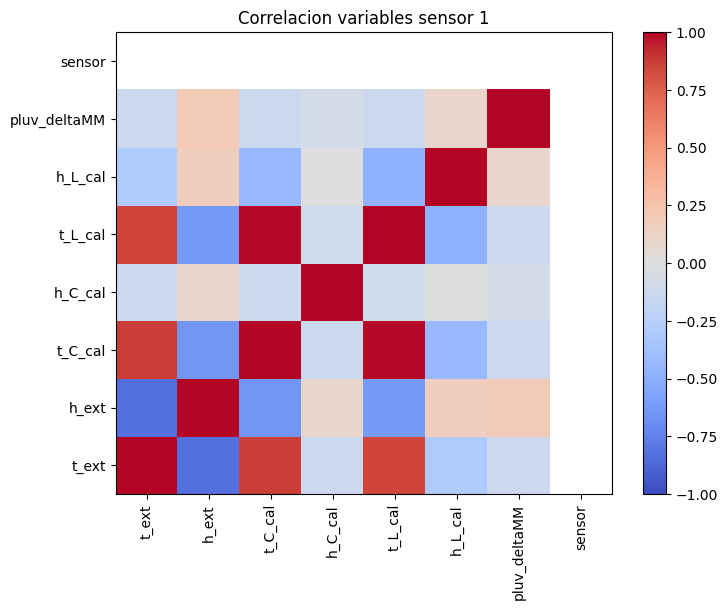

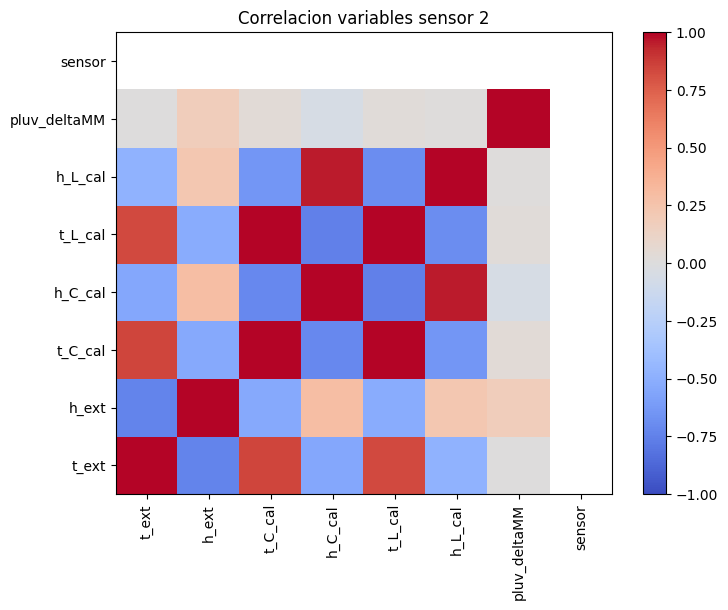

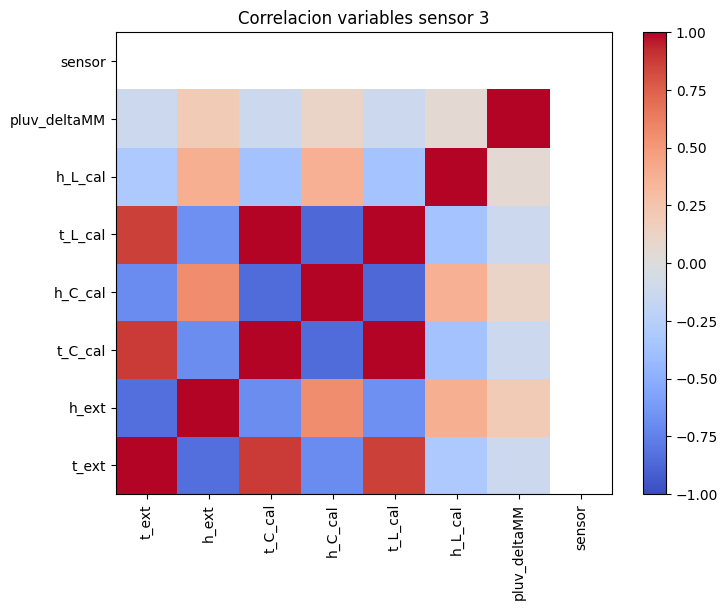

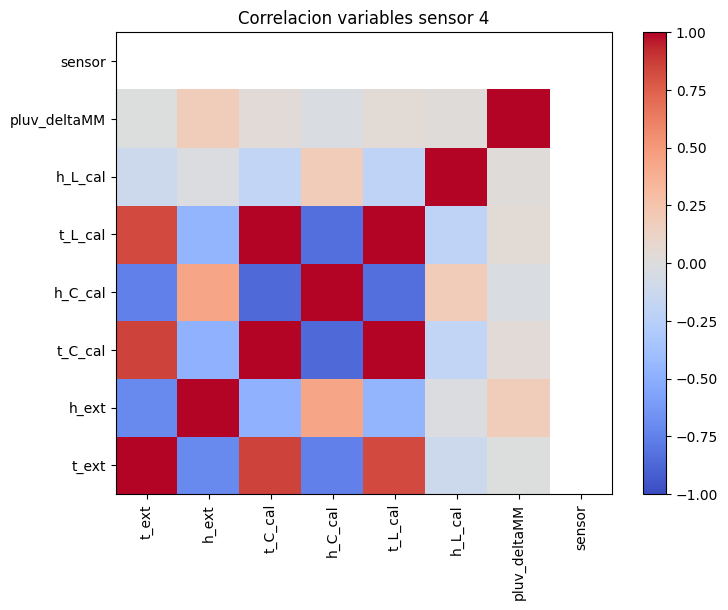

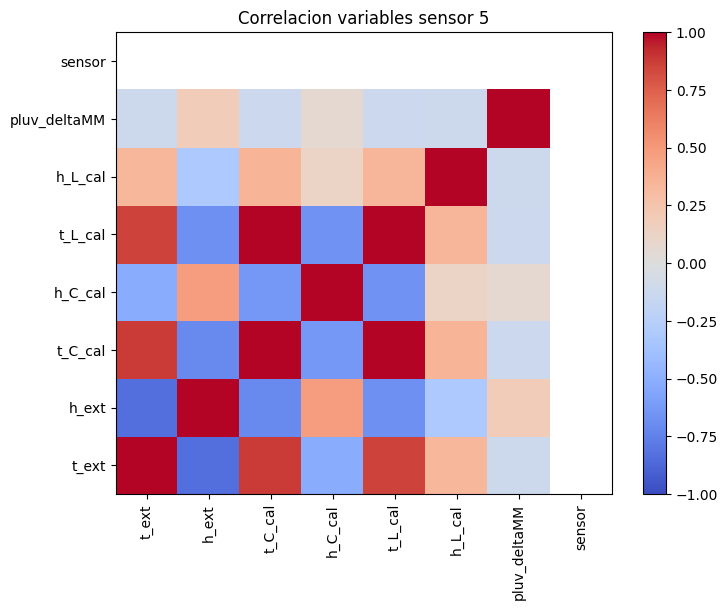

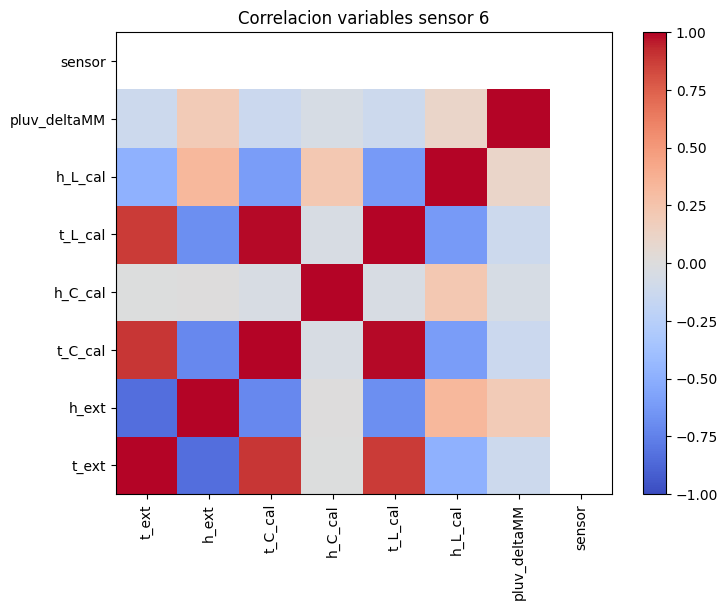

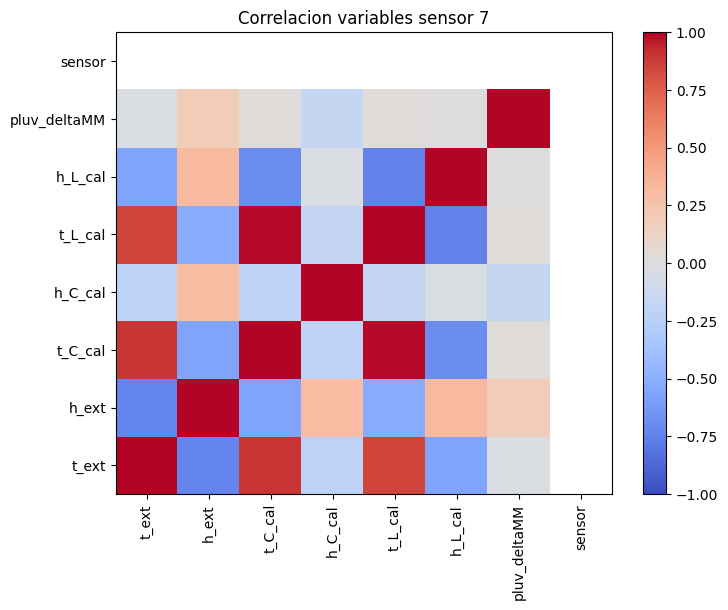

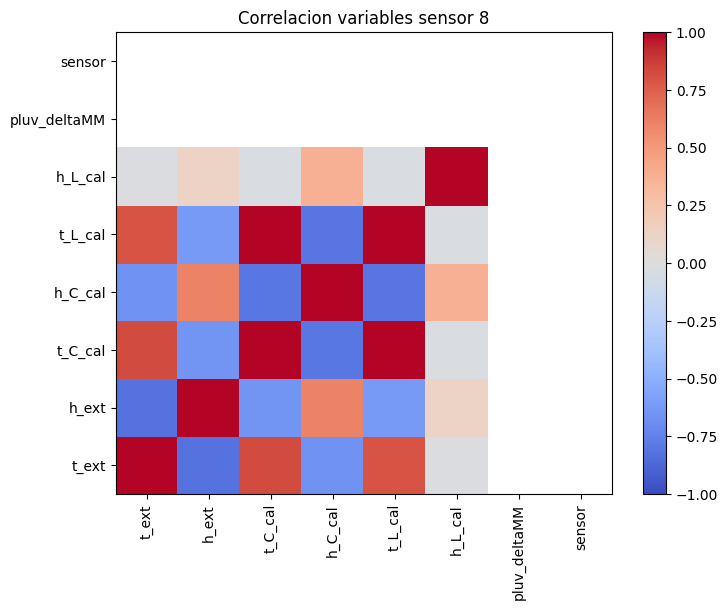

In [13]:
final_df = pd.DataFrame()
for n_sensor, file in enumerate(sensor_files):
    df = pd.read_csv(CLASSIFIED_SENSOR_PATH + file)

    df['ts'] = pd.to_datetime(df['ts'], unit='ns')
    df = pd.merge(df, pluviometer, on='ts', how='left')
    df['sensor'] = pd.Series([n_sensor] * df.shape[0])

    # Introducimos los datos del pluviometro previamente tratados para realizar un estudio
    # de la correlacion con el resto de variables (en la mayoria de los casos esta variable
    # no supera el 20% de correlacion con el resto en niungun sensor)
    df['pluv_deltaMM'] = df['pluv_deltaMM'].interpolate()

    corr_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.title(f"Correlacion variables sensor {n_sensor + 1}")
    heatmap = plt.pcolor(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(heatmap)

    # Etiquetas de los ejes
    plt.xticks(np.arange(0.5, len(corr_matrix.columns), 1), corr_matrix.columns, rotation='vertical')
    plt.yticks(np.arange(0.5, len(corr_matrix.index), 1), corr_matrix.index)

    df = df.drop('pluv_deltaMM', axis=1)

    # Concatenamos el conjunto de datos del sensor actual con el resto para tener los datos
    # integrados
    final_df = pd.concat([final_df, df])
final_df.to_csv(INTEGRATED_FILES_PATH + "/data.csv", index = False)